In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib notebook

In [2]:
freeFloats = pd.read_csv(r'extraCompanyDataFinal/freeFloatBuffered.csv')
sharesOutstanding = pd.read_csv(r'extraCompanyDataFinal/outSharesBuffered.csv')

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]

FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')

In [4]:
#dates for share close prices between any two quarters - for index divisor

quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)


In [5]:
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

In [6]:
quarterCutOffDates

[datetime.date(2017, 6, 19),
 datetime.date(2017, 9, 18),
 datetime.date(2017, 12, 18),
 datetime.date(2018, 3, 19),
 datetime.date(2018, 6, 18),
 datetime.date(2018, 9, 24),
 datetime.date(2018, 12, 24),
 datetime.date(2019, 3, 18),
 datetime.date(2019, 6, 24),
 datetime.date(2019, 9, 23),
 datetime.date(2019, 12, 23)]

In [14]:
indexDivisorsList = []

#iterates over each quarter in 17-19 period
for idx, quarter in enumerate(indexDivisors.index.values):
    #gets index (trading days) for each quarter
    index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values
    
    #makes df using the index and the stocks in FTSE that quarter
    stockMarketCapsEachQuarterOpen = pd.DataFrame(columns = FTSEStocksEachQuarter[quarter].values, index = index)
    stockMarketCapsEachQuarterClose  = pd.DataFrame(columns = FTSEStocksEachQuarter[quarter].values, index = index)
    
    sumOfMarketCaps= 0
    listOfMCs =[]
    
    #iterates over each stock in the FTSE that quarter
    for stock in FTSEStocksEachQuarter[quarter].values:
        
        #imports stock csv
        if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
        else:
            stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
        stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
        
        #calculates market cap for stock over that quarter using free float percentage, shares outsanding and share price
        stockAdjMarkCapsOpen = stockPrice[(stockPrice['Date'] >= quarterCutOffDates[idx]) & (stockPrice['Date'] < quarterCutOffDates[idx+1])]['Open']
        stockAdjMarkCapsClose = stockPrice[(stockPrice['Date'] >= quarterCutOffDates[idx]) & (stockPrice['Date'] < quarterCutOffDates[idx+1])]['Close']
        
        stockAdjMarkCapsOpen = stockAdjMarkCapsOpen.multiply(sharesOutstanding[stock][idx])
        stockAdjMarkCapsOpen = stockAdjMarkCapsOpen.multiply(freeFloats[stock][idx])
        
        stockAdjMarkCapsClose = stockAdjMarkCapsClose.multiply(freeFloats[stock][idx])
        stockAdjMarkCapsClose = stockAdjMarkCapsClose.multiply(sharesOutstanding[stock][idx])
        
        #divides are stocks are traded in pence but market caps are in pounds
        stockAdjMarkCapsOpen = stockAdjMarkCapsOpen.divide(100)
        stockAdjMarkCapsOpen = stockAdjMarkCapsOpen.to_frame()
        stockAdjMarkCapsOpen = stockAdjMarkCapsOpen.set_index(index)
        
        stockAdjMarkCapsClose = stockAdjMarkCapsClose.divide(100)
        stockAdjMarkCapsClose = stockAdjMarkCapsClose.to_frame()
        stockAdjMarkCapsClose = stockAdjMarkCapsClose.set_index(index)
        
        #adds company market caps to dataframe for all companies that quarter
        stockMarketCapsEachQuarterOpen[stock] = stockAdjMarkCapsOpen
        stockMarketCapsEachQuarterClose[stock] = stockAdjMarkCapsClose
        
        
        #finds total MC on the opening morning of the quarter - used to calculate index divisor
        marketCap = (freeFloats[stock][idx]*sharesOutstanding[stock][idx]*stockPrice[stockPrice['Date'] == quarterCutOffDates[idx]]['Open'].values[0])/100
        marketCap = marketCap/100
        sumOfMarketCaps +=marketCap
        
    
    stockMarketCapsEachQuarterOpen.to_csv(f'companyMarketCapsEachQuarter/companyMarketCaps{indexDivisors.index.values[idx]}Open.csv')
    stockMarketCapsEachQuarterClose.to_csv(f'companyMarketCapsEachQuarter/companyMarketCaps{indexDivisors.index.values[idx]}Close.csv')
    
    #finds total market cap each day 
    totalMarketCapOpen = stockMarketCapsEachQuarterOpen.sum(axis=1).to_frame()  
    totalMarketCapClose = stockMarketCapsEachQuarterClose.sum(axis=1).to_frame()  
    
    totalMarketCapOpen.to_csv(f'totalMarketCapsEachQuarter/totalMarketCaps{indexDivisors.index.values[idx]}Open.csv')
    totalMarketCapClose.to_csv(f'totalMarketCapsEachQuarter/totalMarketCaps{indexDivisors.index.values[idx]}Close.csv')
    
    #finds weight of each company each day
    weightsEachDayForQuarterOpen = stockMarketCapsEachQuarterOpen.divide(totalMarketCapOpen[0].values,axis=0)
    weightsEachDayForQuarterClose = stockMarketCapsEachQuarterClose.divide(totalMarketCapClose[0].values,axis=0)
    
    weightsEachDayForQuarterOpen.to_csv(f'companyWeightsEachQuarter/companyWeights{indexDivisors.index.values[idx]}Open.csv')
    weightsEachDayForQuarterClose.to_csv(f'companyWeightsEachQuarter/companyWeights{indexDivisors.index.values[idx]}Close.csv')
    
    #calculates index divisor to make sure price stays continuous over the change in quarter
    if idx == 0:
        #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
        indexDivisorForQuarter = sumOfMarketCaps/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        
    else:
        indexDivisorForQuarter = sumOfMarketCaps/lastPrice
        
    
    indexDivisorsList.append(indexDivisorForQuarter)
    
    #price calculated from MC and index divisor
    FTSEPriceQuarterly = totalMarketCapOpen.divide(indexDivisorForQuarter)
    FTSEPriceQuarterly = FTSEPriceQuarterly.rename(columns={0:"Open"})
    FTSEPriceQuarterly['Close'] = totalMarketCapClose.divide(indexDivisorForQuarter)
    
    #listed in pence
    FTSEPriceQuarterly = FTSEPriceQuarterly.divide(100)
    
    
    
    #last price is used as a reference price - should be close price 
    lastPrice = FTSEPriceQuarterly['Close'].iloc[-1]
    
    
    if idx == 0:
        FTSEPrice3yr = FTSEPriceQuarterly
        
    else:
        FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)
        


indexDivisors['Divisors'] = indexDivisorsList
indexDivisors.to_csv('indexDivisors.csv')

FTSEPrice3yr.to_csv(f'fullSimulatedFTSEPrice.csv')
print(FTSEPrice3yr)


                   Open        Close
2017-06-19  7463.500000  7473.477589
2017-06-20  7482.118071  7411.354287
2017-06-21  7410.726705  7377.258490
2017-06-22  7372.946978  7364.105666
2017-06-23  7350.758979  7351.764564
...                 ...          ...
2019-12-16  7305.611691  7437.543921
2019-12-17  7428.127672  7463.525651
2019-12-18  7448.534398  7482.852106
2019-12-19  7488.377238  7520.091620
2019-12-20  7516.063599  7516.979314

[638 rows x 2 columns]


<IPython.core.display.Javascript object>


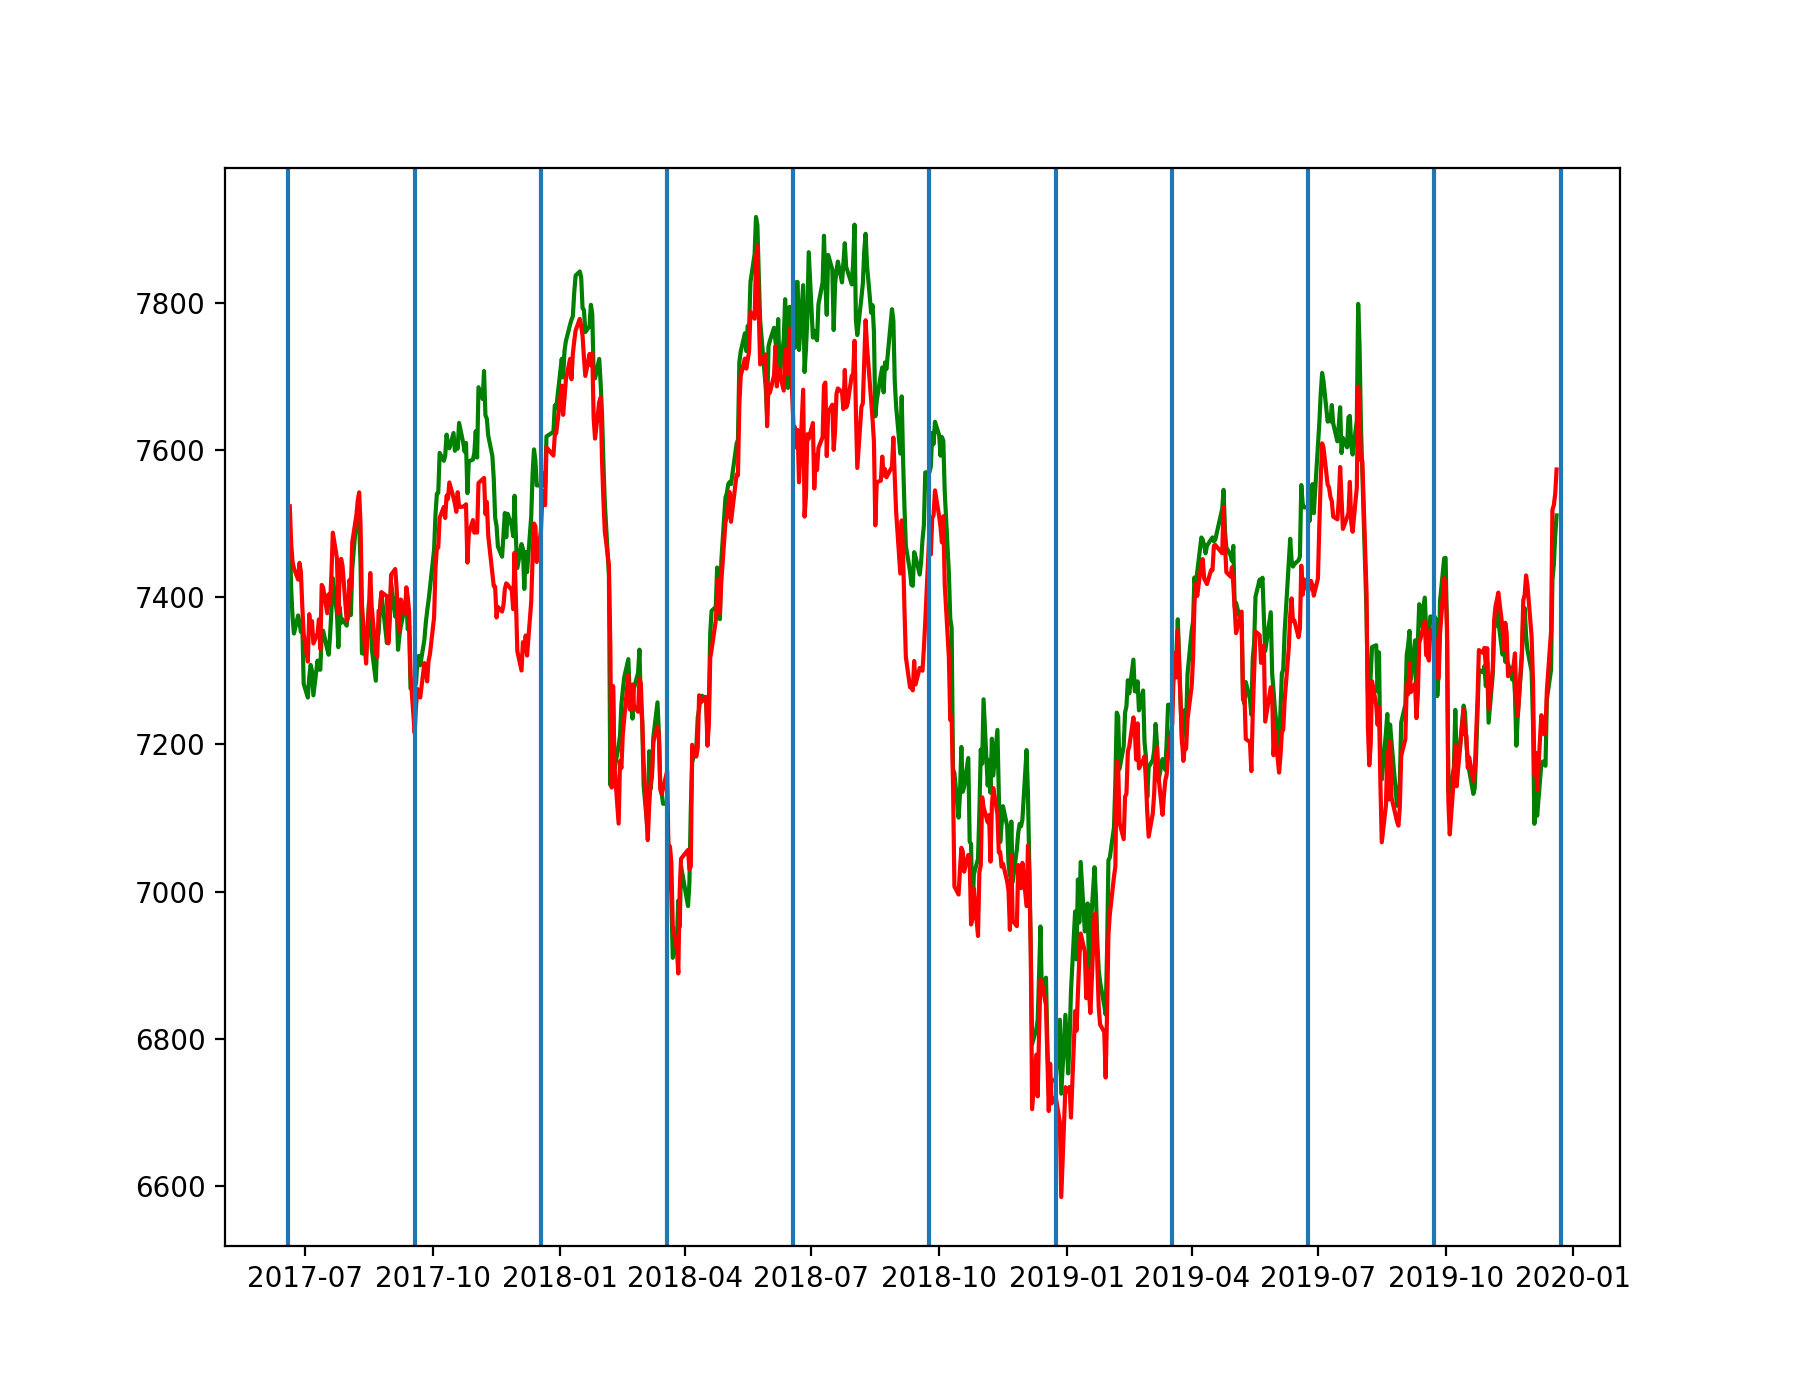

In [140]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(FTSEPrice3yr.index.values,FTSEPrice3yr.values,'g')
axs.plot(FTSEq317date,FTSEq317,'r')
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)
